In [1]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import glob
from sklearn.linear_model import LinearRegression

In [2]:
import pandas.util.testing as tm
import seaborn as sn

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  """Entry point for launching an IPython kernel.


In [3]:
def CDP(f1):
    # dataframe of CDP
    df1 = pd.read_csv(f1, skiprows = 65)
    cdp_time = df1['Second']
    cdp_con = df1['conc(#/L)']

    # creating a concentration matrix to calculte volume based on the diameter range. 
    # units: #/L/um
    cdp_bin = np.array(df1.iloc[:, 2:])

    # CLOUD MASS (g/cc)

    df1['minutes'] = np.array(df1['Second']/60).astype(int)
    minutes = df1['minutes']
    rho = 1 # g/cc

    dia_data = np.array([2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 16, 18, 20, 22, 
                         24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50])
    
    d_width = np.array([(b-a) for a,b in zip(dia_data[::1], dia_data[1::1])])
    d_range = np.ones(cdp_bin.shape)*np.linspace(2, 50, 30) # range of diameters for all the observations.
    V = np.pi * d_range**3 / 6 * 1e-12 # range of volume over all diameters from 2um to 50 um. (um = micro-m). units: cc

#     units of cdp_bin = #/L/um
#     cdp_mass_ = np.sum(V * cdp_bin * d_range * 1e-3, axis = 1) # sum all cloud masses over the diameter range for all observations.
    cdp_mass_ = np.sum(V * cdp_bin * d_width * 1e-3, axis = 1) # sum all cloud masses over the diameter range for all observations.
    df1['liq_water_content (g/cc)'] = cdp_mass_

    min_group = df1.groupby('minutes')

    time = []
    cdp_conc = []
    cdp_mass = []

    for minute,g in min_group:
        time.append(minute)
        cdp_conc.append(g.mask(g['liq_water_content (g/cc)']<1e-7).mean()['conc(#/L)'])
        cdp_mass.append(g.mask(g['liq_water_content (g/cc)']<1e-7).mean()['liq_water_content (g/cc)'])
    
    return df1, cdp_mass_, np.array(time), np.array(cdp_conc), np.array(cdp_mass)
    

In [4]:
# Let's extract the other parameters required for cdp prediction

def params(f1, f4):
    time = CDP(f1)[2]
    df4 = pd.read_csv(f4, delimiter = ',', skiprows = 2, 
                      names = ['IWG1','Date_Time','Lat','Lon','GPS_MSL_Alt','WGS_84_Alt','Press_Alt','Radar_Alt','Grnd_Spd',
                               'True_Airspeed','Indicated_Airspeed','Mach_Number','Vert_Velocity','True_Hdg','Track','Drift',
                               'Pitch','Roll','Side_slip','Angle_of_Attack','Ambient_Temp','Dew_Point','Total_Temp','Static_Press',
                               'Dynamic_Press','Cabin_Pressure','Wind_speed','Wind_Dir','Vert_Wind_Spd','Solar_Zenith','Sun_Elev_AC',
                               'Sun_Az_Grd','Sun_Az_AC','Flag_qc','Flag_ac','Flag_Diluter','Flag_cloud','Flag_cloudP','RH_water',
                               'RH_ice','Theta','Cabin_Temperature','Q_Dilution','Q_bypass','D_ratio','Leg_num'])

    df4['Date_Time'] = pd.to_datetime(df4['Date_Time']) # convert the give Date_Time object to datetime series for timestamp indexing.
    df4['minutes'] = df4['Date_Time'].dt.strftime('%H').astype(int)*60 + df4['Date_Time'].dt.strftime('%M').astype(int)

    df4 = df4.groupby('minutes').mean()

    i3, = np.where(df4.index == time[0])
    i4, = np.where(df4.index == time[-1])

    df4 = df4[i3[0]:i4[0]+1]
    
    return np.array(df4['GPS_MSL_Alt']), np.array(df4['Ambient_Temp']), np.array(df4['Dew_Point'])

In [5]:
path1 = r'C:\Users\adity\MS_Thesis\Go-Amazon-selected\cdp'
path2 = r'C:\Users\adity\MS_Thesis\Go-Amazon-selected\ccn'
path3 = r'C:\Users\adity\MS_Thesis\Go-Amazon-selected\ppc_velocity'
path4 = r'C:\Users\adity\MS_Thesis\Go-Amazon-selected\aimms_params'
path5 = r'C:\Users\adity\MS_Thesis\Go-Amazon-selected\comstock-2dsh'    

In [6]:
files1 = glob.glob(path1 + '/*.ict')
files2 = glob.glob(path2 + '/*.ict')
files3 = glob.glob(path3 + '/*.ppc')
files4 = glob.glob(path4 + '/*.txt')
files5 = glob.glob(path5 + '/*.ict')

In [7]:
df = pd.read_csv('clean_data_with_rain.csv')
df

,time (min),cdp_conc (#/cc),cdp_mass (g/cc),ccn_conc (#/cc),altitude (m),ambient_temp (degC),dew_pt (degC),Velocity_mean (m/s),Velocity_std (m/s),non-nan counter,rain_conc (#/cc),rain_mass (g/cc),RH (%)
0,1038,525.690667,1.919149e-07,156.452830,963.566667,23.841667,20.235000,0.369500,0.532001,3,0.000000,0.000000e+00,80.261559
1,1039,368.329500,1.454731e-07,303.037500,1088.200000,23.096667,18.541667,0.256750,0.603507,2,0.000005,0.000000e+00,75.557647
2,1040,102.763850,3.613746e-07,157.620000,1106.700000,22.728333,19.518333,-3.667917,3.206158,6,0.006904,7.544186e-12,82.114718
3,1041,91.984218,3.244988e-07,141.256250,1101.366667,22.521667,20.270000,-2.146750,4.388065,22,0.013811,1.702631e-11,87.115427
4,1044,104.497209,3.478628e-07,115.815385,1106.300000,22.250000,21.186667,-2.470514,4.703326,35,0.000000,5.770725e-11,93.708633
...,...,...,...,...,...,...,...,...,...,...,...,...,...
576,1039,336.723125,1.939796e-06,252.366667,5410.750000,-4.995000,-12.473333,2.724875,3.456326,8,0.856624,0.000000e+00,55.785574
577,1041,64.223822,3.003772e-07,137.113043,5669.283333,-6.058333,-9.260000,2.410944,0.979870,9,0.282132,5.079032e-08,78.071209
578,1043,84.528400,7.576585e-07,162.792453,5809.600000,-8.041667,-10.925000,1.837099,0.308029,4,0.000021,1.862939e-11,79.737525
579,1044,73.727075,5.766109e-07,155.333333,5816.183333,-8.351667,-12.308333,3.934125,1.480924,4,0.000468,7.077102e-10,73.125344


In [8]:
def params_lat(f1, f4):
    time = CDP(f1)[2]
    df4 = pd.read_csv(f4, delimiter = ',', skiprows = 2, 
                      names = ['IWG1','Date_Time','Lat','Lon','GPS_MSL_Alt','WGS_84_Alt','Press_Alt','Radar_Alt','Grnd_Spd',
                               'True_Airspeed','Indicated_Airspeed','Mach_Number','Vert_Velocity','True_Hdg','Track','Drift',
                               'Pitch','Roll','Side_slip','Angle_of_Attack','Ambient_Temp','Dew_Point','Total_Temp','Static_Press',
                               'Dynamic_Press','Cabin_Pressure','Wind_speed','Wind_Dir','Vert_Wind_Spd','Solar_Zenith','Sun_Elev_AC',
                               'Sun_Az_Grd','Sun_Az_AC','Flag_qc','Flag_ac','Flag_Diluter','Flag_cloud','Flag_cloudP','RH_water',
                               'RH_ice','Theta','Cabin_Temperature','Q_Dilution','Q_bypass','D_ratio','Leg_num'])

    df4['Date_Time'] = pd.to_datetime(df4['Date_Time']) # convert the give Date_Time object to datetime series for timestamp indexing.
    df4['minutes'] = df4['Date_Time'].dt.strftime('%H').astype(int)*60 + df4['Date_Time'].dt.strftime('%M').astype(int)

    df4 = df4.groupby('minutes').mean()

    i3, = np.where(df4.index == time[0])
    i4, = np.where(df4.index == time[-1])

    df4 = df4[i3[0]:i4[0]+1]
    
    return df4

In [9]:
def speed(f1, f3):
    df1 = CDP(f1)[0]
    cdp_mass_ = CDP(f1)[1]

    # dataframe for updraft velocity
    df3 = pd.read_csv(f3, delimiter = '\s+', skiprows = 2, 
                      names = ['UTC Time (decimal hours)', 'Temp (deg C)', 'Humidity (%RH)', 
                               'Barometric Press (Pa)', 'North Wind component (m/s)', 'East Wind component (m/s)', 
                               'GPS Latitude (decimal degrees)', 'GPS Longitude (decimal degrees)', 
                               'GPS Altitude (decimal degrees)',
                               'Aircraft longitudinal inertial velocity (m/s)', 'Aircraft Lateral inertial velocity (m/s)', 
                               'Aircraft vertical velocity (m/s)', 'Roll (degrees)', 'Pitch (degrees)', 'Yaw/Heading (degrees)', 
                               'True Air speed [TAS] (m/s)', 'Vertical wind velocity (m/s)',
                               'dimensional sideslip angle (degrees)', 'non-dimensional angle-of-attack', 
                               'non-dimensional sideslip angle', 'Wind status flag']).drop(0) 

    df3['seconds'] = (np.array(df3['UTC Time (decimal hours)']*3600).astype(int))
    df3['v^2'] = df3['Vertical wind velocity (m/s)']**2

    df3 = df3.groupby('seconds').mean()

    i1, = np.where(df3.index == df1['Second'].iloc[0])
    i2, = np.where(df3.index == df1['Second'].iloc[-1])

    df3 = df3[i1[0]:i2[0]+1]

    df3['minutes'] = np.array(df3.index/60).astype(int)
    df3['liq_water_content (g/cc)'] = cdp_mass_
    min_group3 = df3.groupby('minutes')

    avg = []
    std = []
    ctr = []

    for m, g in min_group3:
            x,x2 = g.mask(g['liq_water_content (g/cc)']<1e-6).mean()[['Vertical wind velocity (m/s)', 'v^2']]
            ctr.append(g.mask(g['liq_water_content (g/cc)']<1e-6).count()['Vertical wind velocity (m/s)'])
            avg.append(x)
            std.append(x2 - x**2)
            
    return np.array(avg), np.array(std), np.array(ctr)


In [100]:
total_cloudy_obs = []

# finding the total number of cloudy data points in every cloud file

for i in range(17):
    # removing all the values where the cdp_conc is Nan value.
    total_cloudy_obs.append(len(np.where(np.logical_not(np.isnan(CDP(files1[i])[3])))[0]))


In [99]:
# i = 3
# len(np.where(np.logical_not(np.isnan(CDP(files1[i])[3])))[0])

28

In [103]:
total_cloudy_obs

[17, 0, 16, 28, 65, 33, 38, 18, 17, 40, 85, 35, 31, 31, 8, 41, 78]

In [10]:
from matplotlib.collections import LineCollection
import cartopy.crs as ccrs

In [11]:
import matplotlib.cm as cm
import matplotlib as mpl
from matplotlib.colors import ListedColormap, BoundaryNorm

In [22]:
dateiso_arr = np.array(['2014-03-01', '2014-03-03', '2014-03-07', '2014-03-10', '2014-03-12', '2014-03-13', 
                    '2014-03-16', '2014-03-17', '2014-03-19', '2014-03-21', '2014-03-23', '2014-09-09',
                    '2014-09-13','2014-09-19', '2014-09-28', '2014-10-01', '2014-10-03']) 

In [15]:
# 0: terra, 1: aqua
terra_aqua = np.array([1, 1, 0, 0, 1, 0, 0, 0, 0,
                       1, 1, 1, 0, 1, 0, 0, 1])

In [ ]:
# for i, j, k, l in zip(files1, files5, dateiso, terra_aqua):
#     print(i,j,k,l)


In [ ]:
# # i = files1[0]
# # j = files4[0]
# # dateiso = np.array(['2014-03-01', '2014-03-09'])

# for i,j,k in zip(files1, files4, dateiso):
#     lat_timeseries = np.array(params_lat(i,j)['Lat'])
#     lon_timeseries = np.array(params_lat(i,j)['Lon'])
#     alt_timeseries = np.array(params(i,j)[0])

#     fig = plt.figure(figsize = (12, 8))
    
# #     print(k)
#     dateiso = k
    
#     # Aqua and Terra satelite image plots
#     ax = fig.add_subplot(121, projection=ccrs.PlateCarree()) # we need to project geospatial coordinates hence, projection. 
#     # ax.plot(lon_timeseries, lat_timeseries)

#     ax.add_wmts('https://gibs.earthdata.nasa.gov/wmts/epsg4326/best/wmts.cgi', 
#                  'MODIS_Aqua_CorrectedReflectance_TrueColor', wmts_kwargs={'time': dateiso})

#     # ax.add_wmts('https://gibs.earthdata.nasa.gov/wmts/epsg4326/best/wmts.cgi', 
#     #              'MODIS_Terra_CorrectedReflectance_TrueColor', wmts_kwargs={'time': dateiso})

#     cmap=plt.get_cmap('jet')
#     cmap.set_under('w')
#     cmap.set_over('k')

#     norm = BoundaryNorm(np.array([0,200,400,600,800,1000,1200,1400,1600])*5, cmap.N, clip=False)
#     points = np.array([lon_timeseries, lat_timeseries]).T.reshape(-1, 1, 2)
#     segments = np.concatenate([points[:-1], points[1:]], axis=1)

#     lc = LineCollection(segments, cmap=cmap,norm=norm)
#     lc.set_array(np.asarray(alt_timeseries))
#     lc.set_linewidth(4)

#     ax.add_collection(lc)
#     axcb = fig.colorbar(lc)
#     axcb.set_label('altitude (m)')

#     ax.set_xlim(min(lon_timeseries), max(lon_timeseries))
#     ax.set_ylim(min(lat_timeseries), max(lat_timeseries))

#     ax.gridlines(draw_labels = True)
    
# #     # CLoud top height plot
# #     ax1 = fig.add_subplot(122, projection=ccrs.PlateCarree())
# #     ax1.plot(lon_timeseries, lat_timeseries)

# #     ax1.add_wmts('https://gibs.earthdata.nasa.gov/wmts/epsg4326/best/wmts.cgi', 
# #                  'MODIS_Aqua_Cloud_Top_Height_Day', wmts_kwargs={'time': dateiso})

# #     ax1.gridlines(draw_labels = True)

# #     plt.subplots_adjust(wspace = 0.5)
# #     plt.suptitle(f'Date: {dateiso}')
# #     plt.show()

In [105]:
aqua_terra = ['aqua', 'aqua', 'terra', 'terra', 'aqua', 'terra', 'terra', 'terra', 'terra', 
              'aqua', 'aqua', 'aqua', 'terra', 'aqua', 'terra', 'terra', 'aqua']

C:\ProgramData\Anaconda3\lib\site-packages\owslib\wmts.py:643: RuntimeWarning: TileMatrixLimits with tileMatrix "1" already exists
  warnings.warn(msg, RuntimeWarning)
C:\ProgramData\Anaconda3\lib\site-packages\owslib\wmts.py:643: RuntimeWarning: TileMatrixLimits with tileMatrix "2" already exists
  warnings.warn(msg, RuntimeWarning)
C:\ProgramData\Anaconda3\lib\site-packages\owslib\wmts.py:643: RuntimeWarning: TileMatrixLimits with tileMatrix "3" already exists
  warnings.warn(msg, RuntimeWarning)
C:\ProgramData\Anaconda3\lib\site-packages\owslib\wmts.py:643: RuntimeWarning: TileMatrixLimits with tileMatrix "4" already exists
  warnings.warn(msg, RuntimeWarning)
C:\ProgramData\Anaconda3\lib\site-packages\owslib\wmts.py:643: RuntimeWarning: TileMatrixLimits with tileMatrix "5" already exists
  warnings.warn(msg, RuntimeWarning)
C:\ProgramData\Anaconda3\lib\site-packages\owslib\wmts.py:643: RuntimeWarning: TileMatrixLimits with tileMatrix "6" already exists
  warnings.warn(msg, RuntimeW

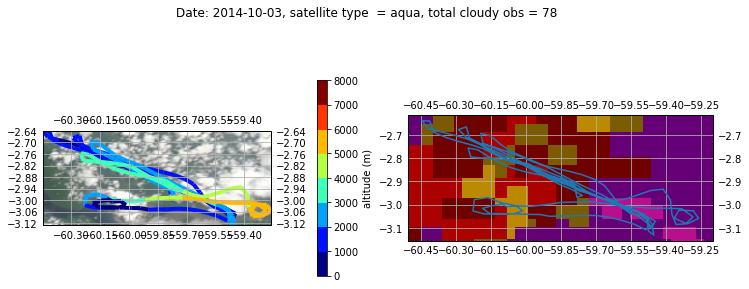

In [124]:
ct = 16
i = files1[ct]
j = files4[ct]

dateiso = dateiso_arr[ct]
# sat_type = 'terra'
sat_type = aqua_terra[ct]

if sat_type == 'terra':
    k_type = 'MODIS_Terra_CorrectedReflectance_TrueColor'
    c_type = 'MODIS_Terra_Cloud_Top_Height_Day'
    
else:
    k_type = 'MODIS_Aqua_CorrectedReflectance_TrueColor'
    c_type = 'MODIS_Aqua_Cloud_Top_Height_Day'

lat_timeseries = np.array(params_lat(i,j)['Lat'])
lon_timeseries = np.array(params_lat(i,j)['Lon'])
alt_timeseries = np.array(params(i,j)[0])

fig = plt.figure(figsize = (12, 8))

# Aqua and Terra satelite image plots
ax = fig.add_subplot(121, projection=ccrs.PlateCarree()) # we need to project geospatial coordinates hence, projection. 
# ax.plot(lon_timeseries, lat_timeseries)

ax.add_wmts('https://gibs.earthdata.nasa.gov/wmts/epsg4326/best/wmts.cgi', 
             k_type, wmts_kwargs={'time': dateiso})

cmap=plt.get_cmap('jet')
cmap.set_under('w')
cmap.set_over('k')

norm = BoundaryNorm(np.array([0,200,400,600,800,1000,1200,1400,1600])*5, cmap.N, clip=False)
points = np.array([lon_timeseries, lat_timeseries]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)

lc = LineCollection(segments, cmap=cmap,norm=norm)
lc.set_array(np.asarray(alt_timeseries))
lc.set_linewidth(4)

ax.add_collection(lc)
axcb = fig.colorbar(lc, fraction = 0.1, shrink = 0.45, pad = 0.15)
axcb.set_label('altitude (m)')

ax.set_xlim(min(lon_timeseries), max(lon_timeseries))
ax.set_ylim(min(lat_timeseries), max(lat_timeseries))

ax.gridlines(draw_labels = True)

# CLoud top height plot

ax1 = fig.add_subplot(122, projection=ccrs.PlateCarree())
ax1.plot(lon_timeseries, lat_timeseries)

ax1.add_wmts('https://gibs.earthdata.nasa.gov/wmts/epsg4326/best/wmts.cgi', 
             c_type, wmts_kwargs={'time': dateiso})

ax1.gridlines(draw_labels = True)

# plt.subplots_adjust(wspace = 0.5)
plt.suptitle(f'Date: {dateiso}, satellite type  = {sat_type}, total cloudy obs = {total_cloudy_obs[ct]}', y = 0.8)
plt.show()

In [13]:
from scipy.io import netcdf
from netCDF4 import Dataset
import numpy.ma as ma

path6 = r'C:\Users\adity\MS_Thesis\Go-Amazon-selected\ncdf - 1'
files6 = glob.glob(path6 + '/*.nc')

d = Dataset(files6[0])

var = d.variables
var
len(files6)

51

In [14]:
# d.variables['z0'][:]

In [19]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [35]:
left_alt_arr = [2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 
                1.5, 1.5, 1.5, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 
                1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5]

right_alt_arr = [7.5, 7.5, 7.5, 6.0, 6.0, 6.0, 3.5, 3.5, 3.5, 2.5, 2.5, 2.5, 3.0, 3.0, 3.0, 4.5, 4.5, 4.5, 6.5, 6.5, 6.5, 
                 6.5, 6.5, 6.5, 2.5, 2.5, 2.5, 2.5, 2.5, 2.5, 5.5, 5.5, 5.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 
                 3.5, 3.5, 3.5, 3.5, 3.5, 3.5, 6.0, 6.0, 6.0]

ct_arr = [0, 0, 0, 1, 1, 1, 2, 2, 2, 3, 3, 3, 4, 4, 4, 5, 5, 5, 6, 6, 6, 7, 7, 7, 8, 8, 8, 9, 9, 9, 10, 10, 10, 
          11, 11, 11, 12, 12, 12, 13, 13, 13, 14, 14, 14, 15, 15, 15, 16, 16, 16]

dateiso_arr_1 = np.array(['2014-03-01', '2014-03-01', '2014-03-01',
                          '2014-03-03', '2014-03-03', '2014-03-03',
                          '2014-03-07', '2014-03-07', '2014-03-07', 
                          '2014-03-10', '2014-03-10', '2014-03-10', 
                          '2014-03-12', '2014-03-12', '2014-03-12', 
                          '2014-03-13', '2014-03-13', '2014-03-13',  
                          '2014-03-16', '2014-03-16', '2014-03-16', 
                          '2014-03-17', '2014-03-17', '2014-03-17', 
                          '2014-03-19', '2014-03-19', '2014-03-19', 
                          '2014-03-21', '2014-03-21', '2014-03-21', 
                          '2014-03-23', '2014-03-23', '2014-03-23', 
                          '2014-09-09', '2014-09-09', '2014-09-09', 
                          '2014-09-13', '2014-09-13', '2014-09-13',
                          '2014-09-19', '2014-09-19', '2014-09-19', 
                          '2014-09-28', '2014-09-28', '2014-09-28', 
                          '2014-10-01', '2014-10-01', '2014-10-01',
                          '2014-10-03', '2014-10-03', '2014-10-03']) 
len(dateiso_arr_1)

51

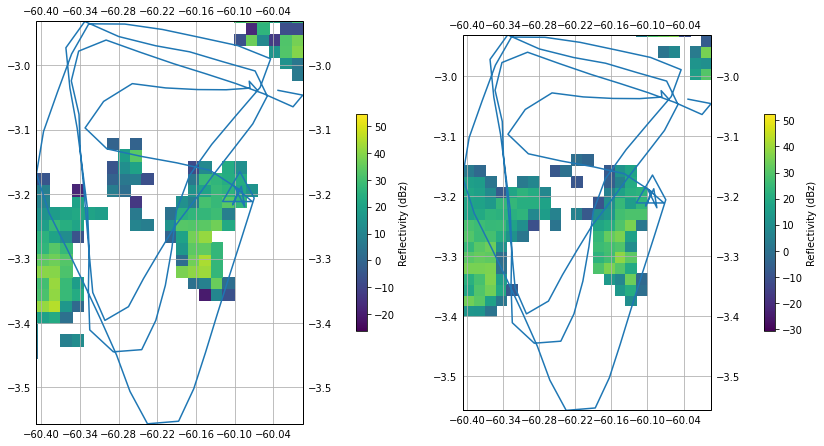

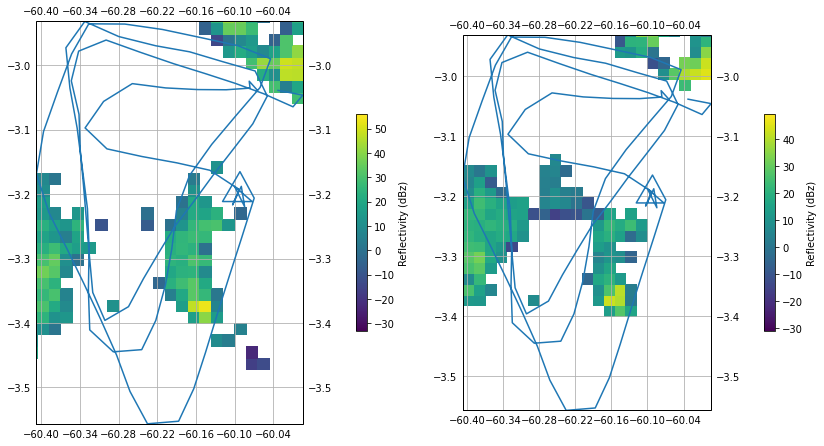

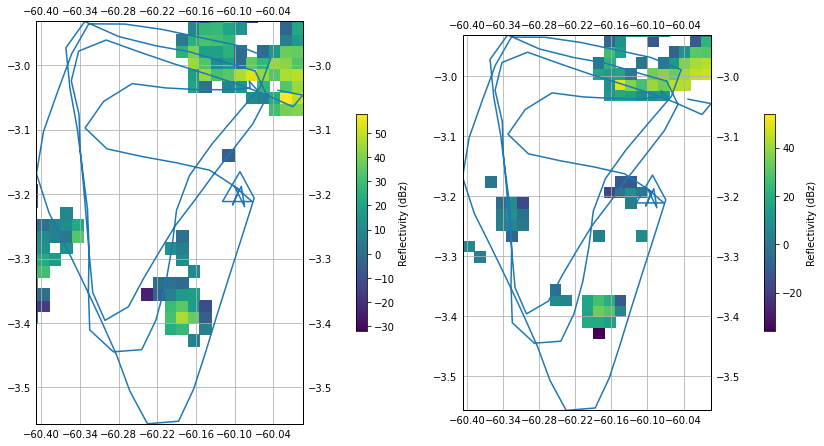

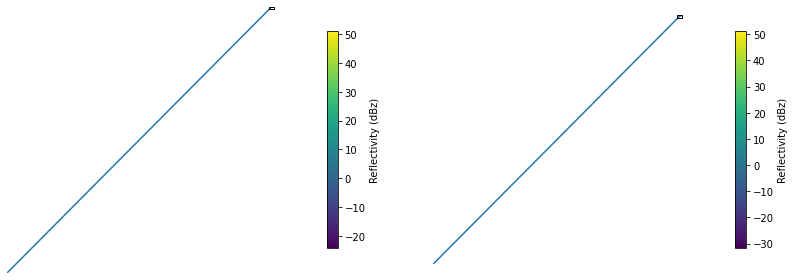

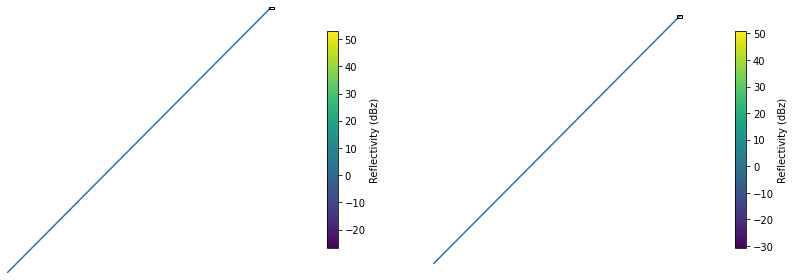

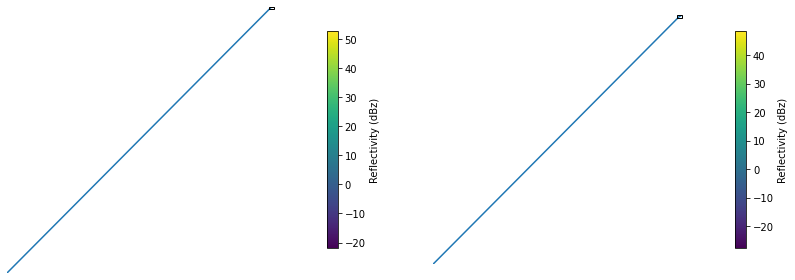

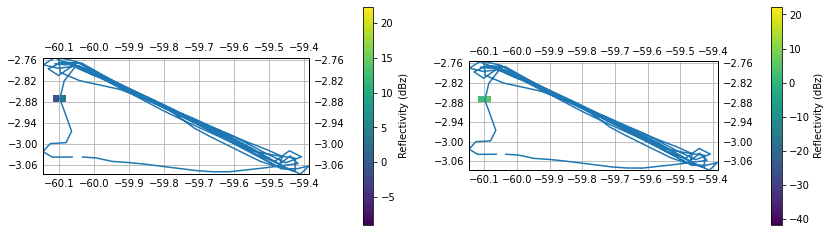

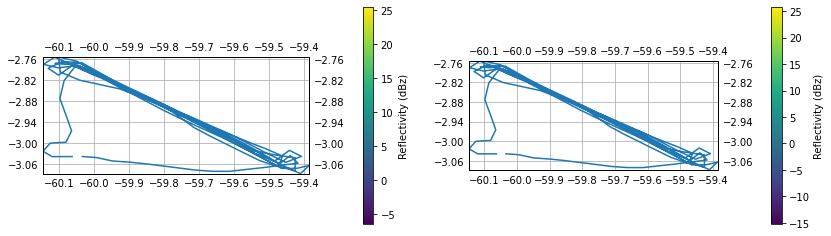

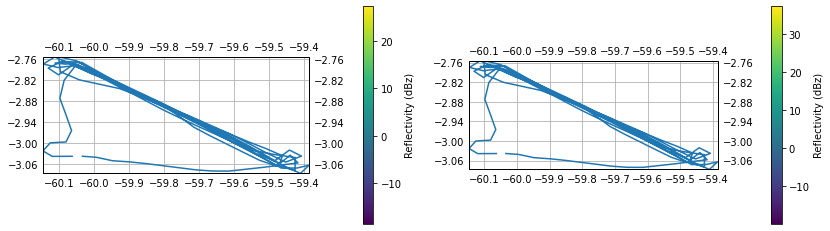

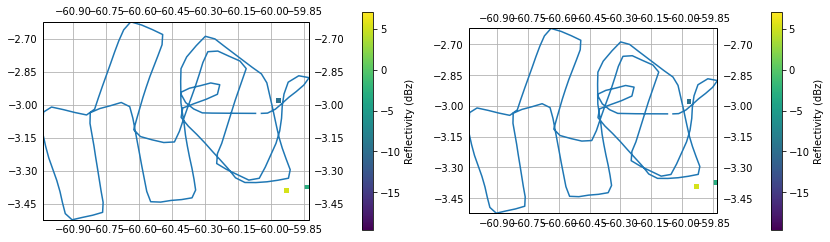

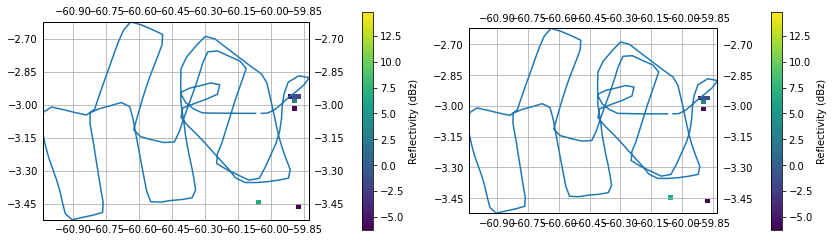

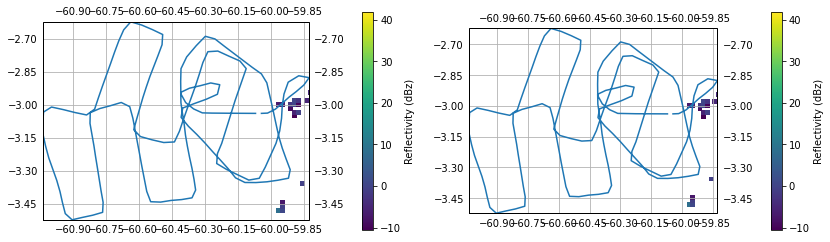

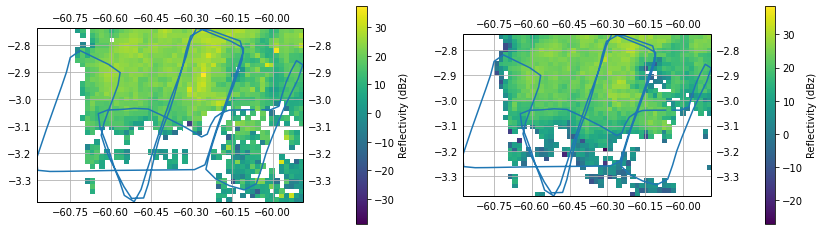

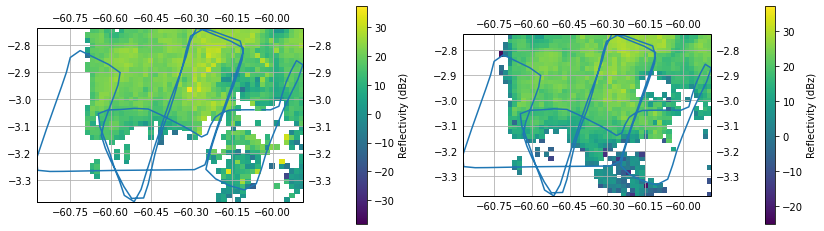

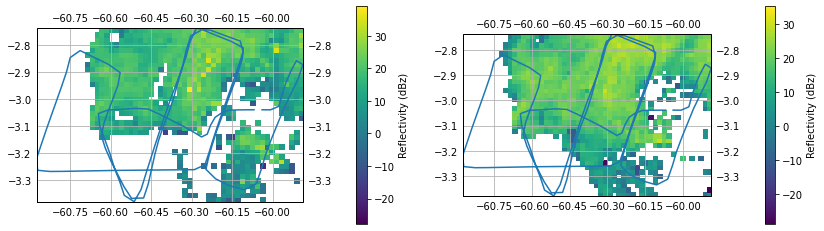

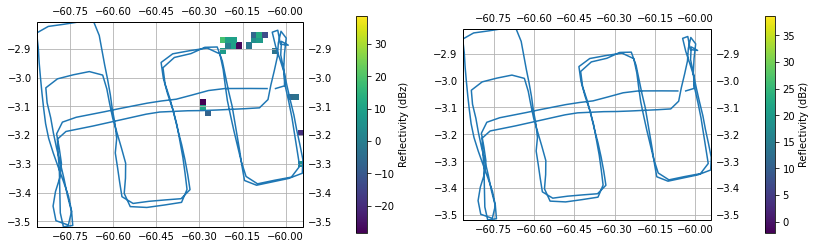

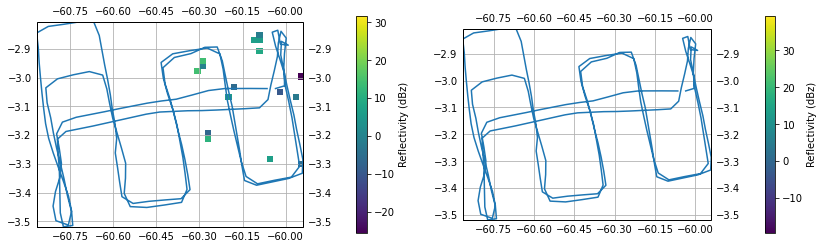

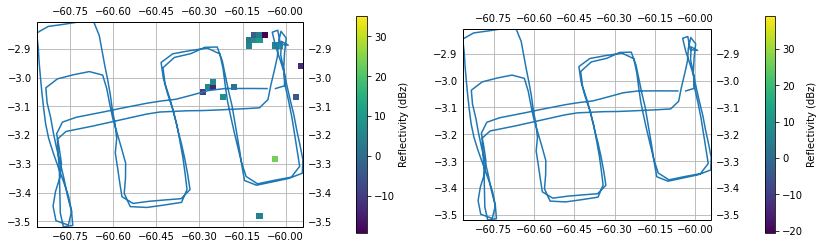

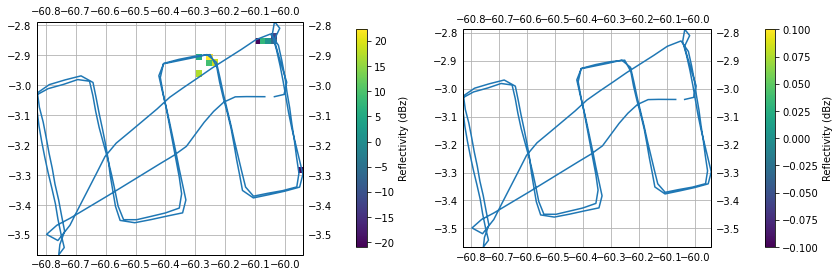

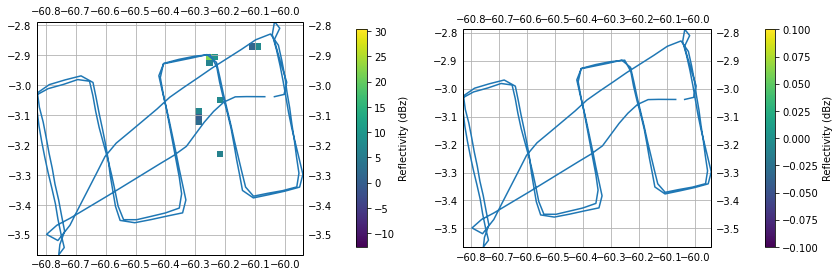

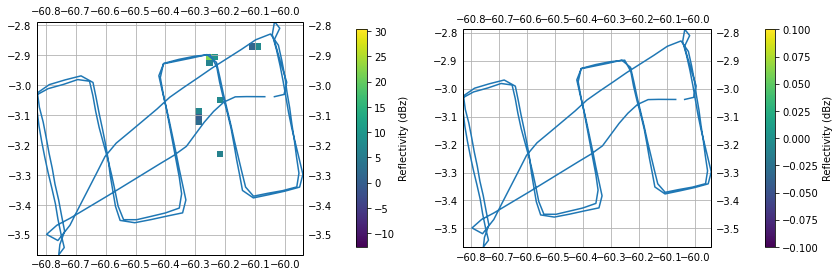

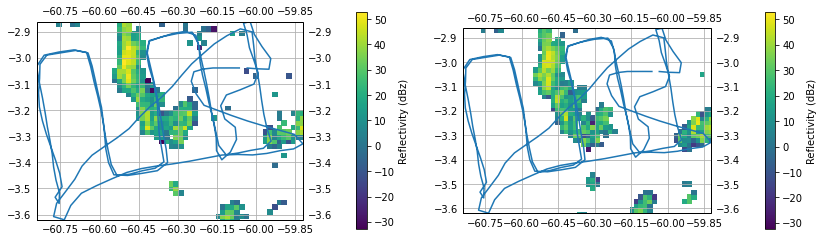

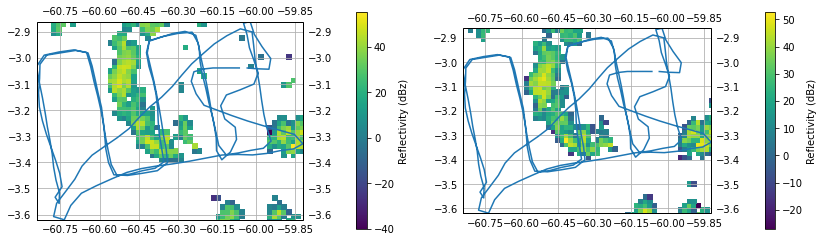

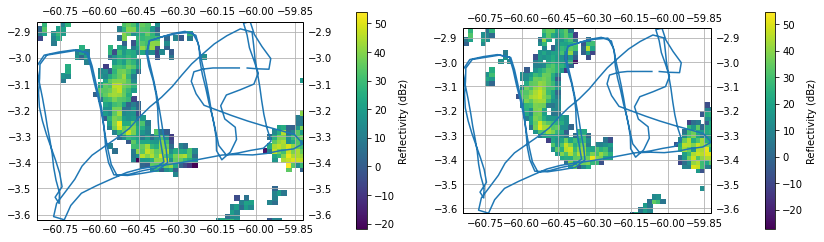

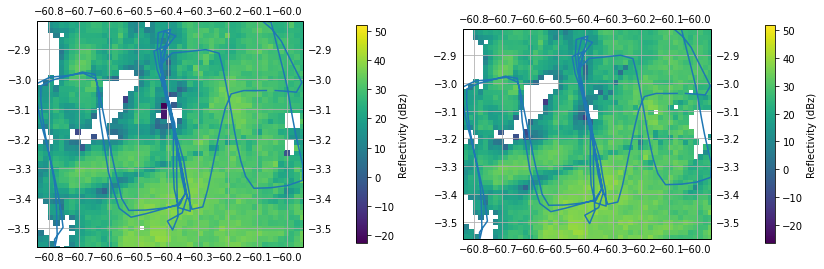

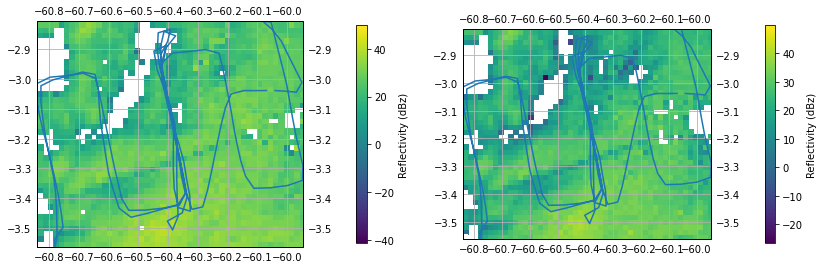

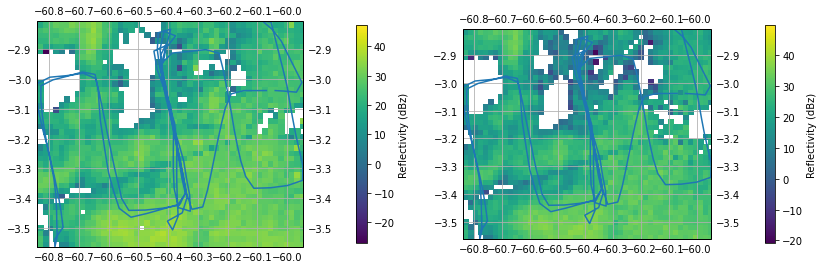

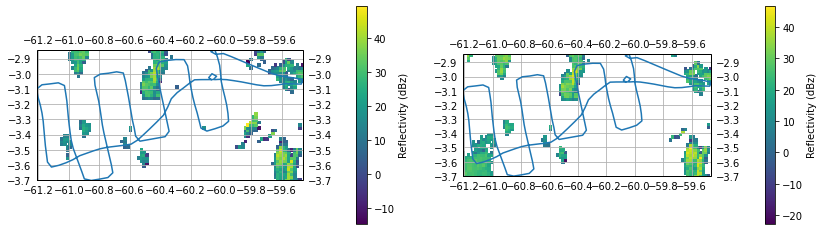

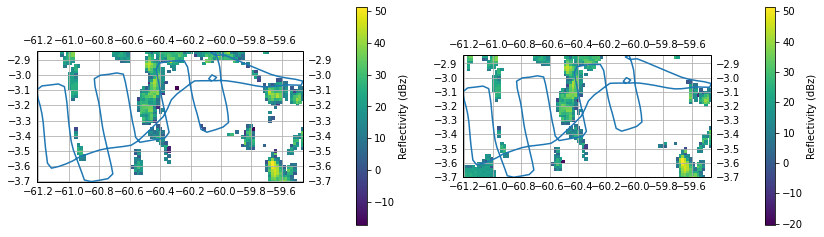

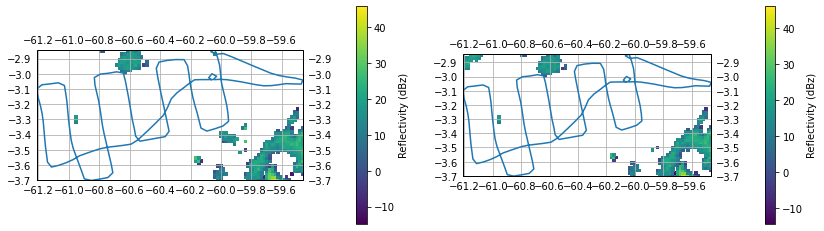

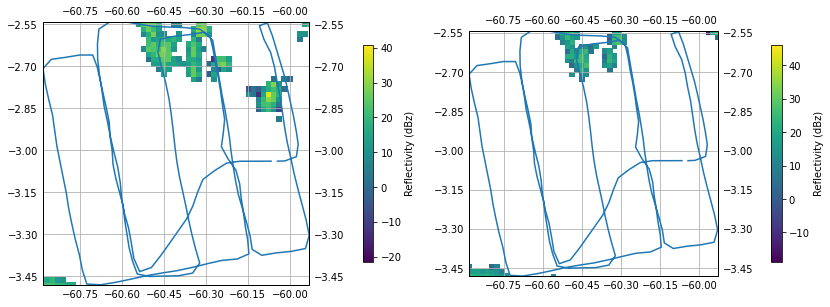

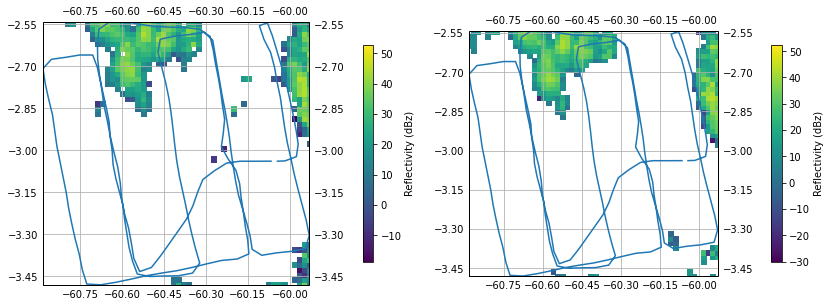

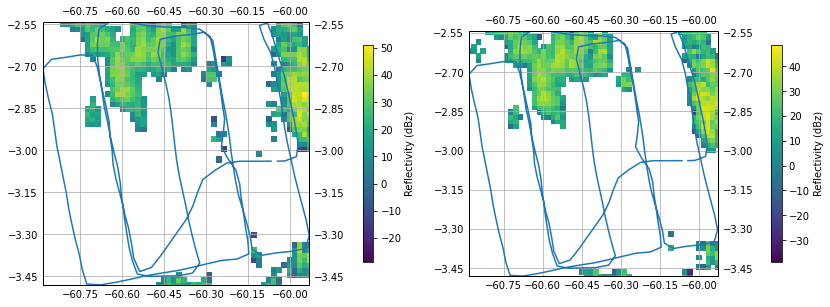

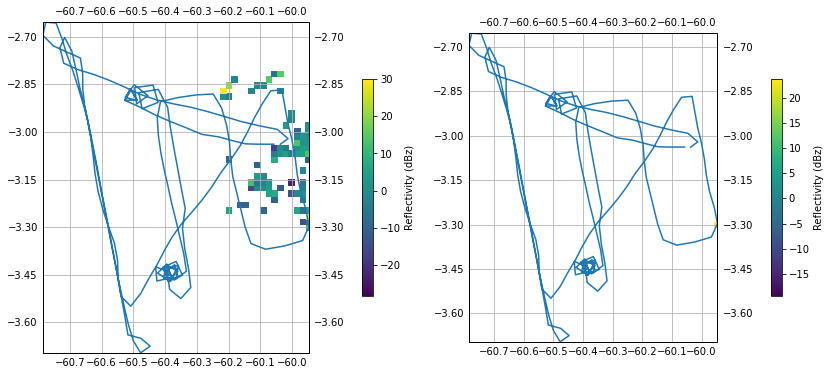

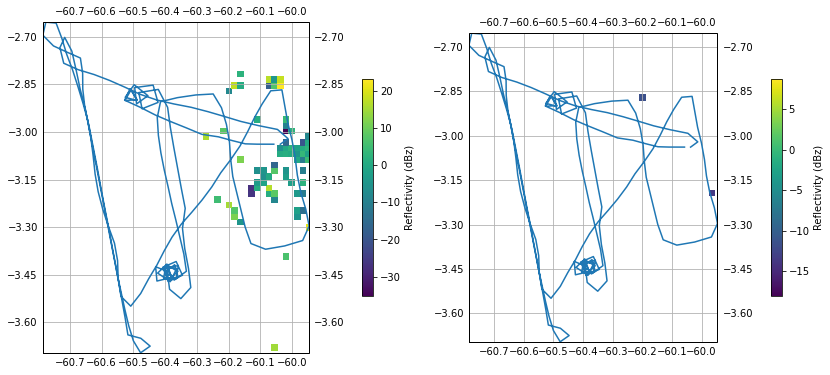

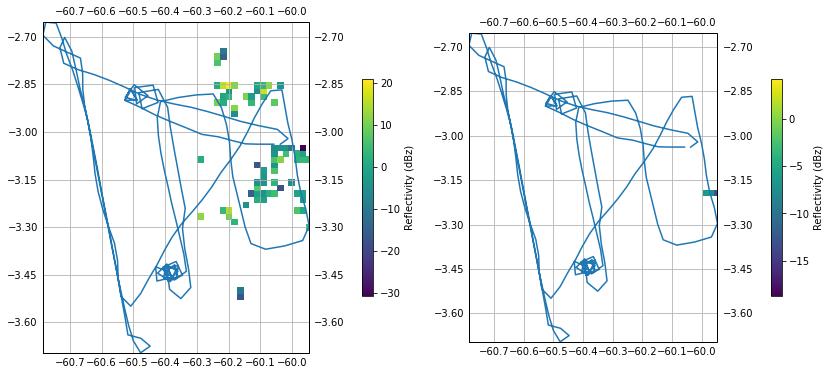

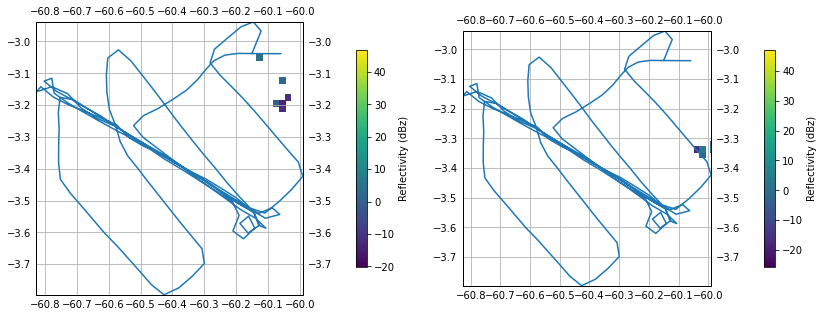

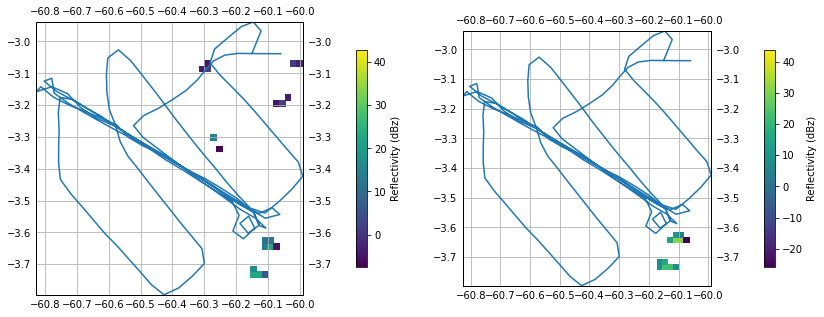

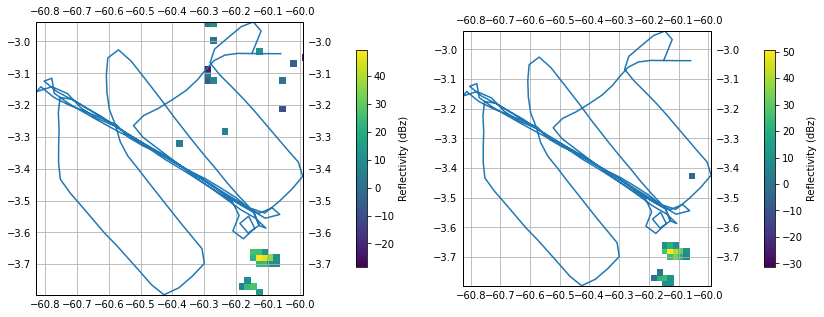

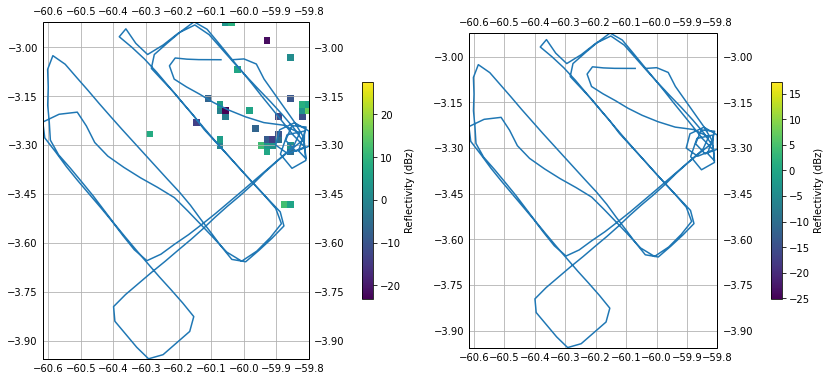

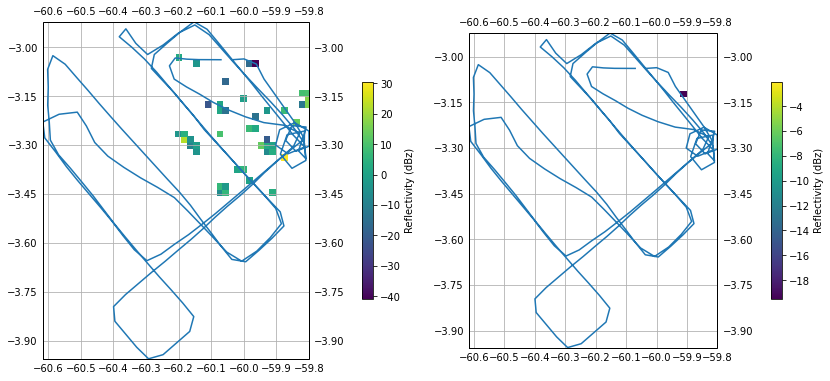

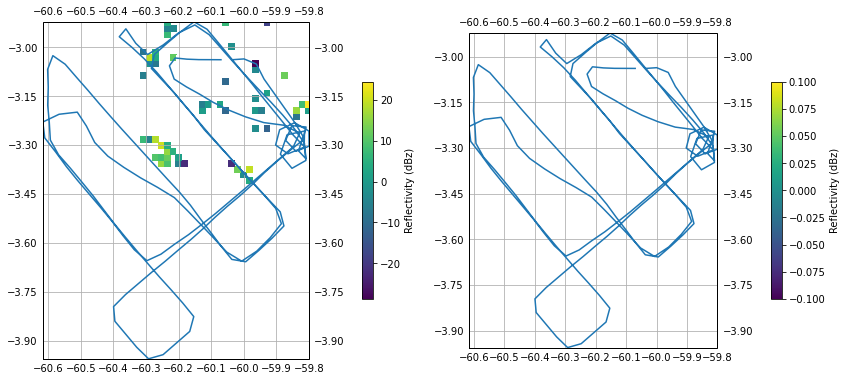

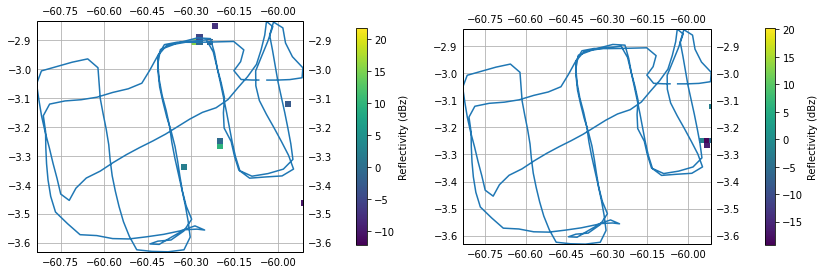

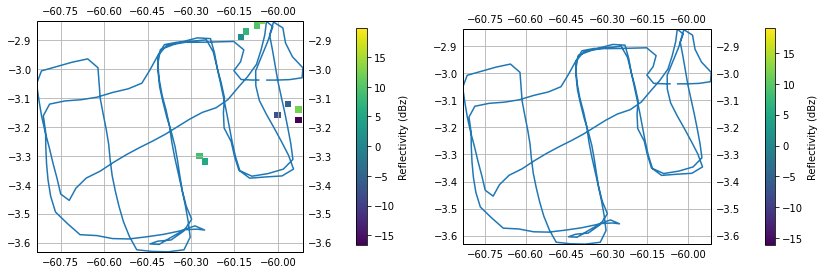

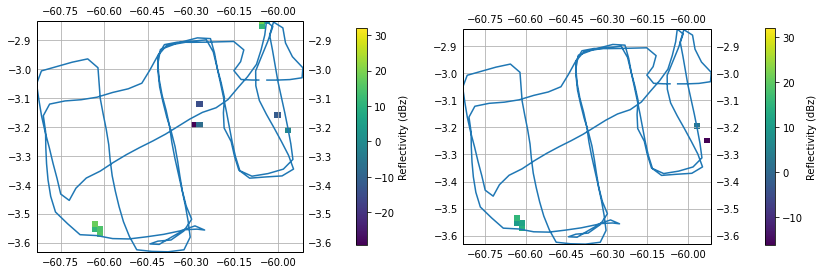

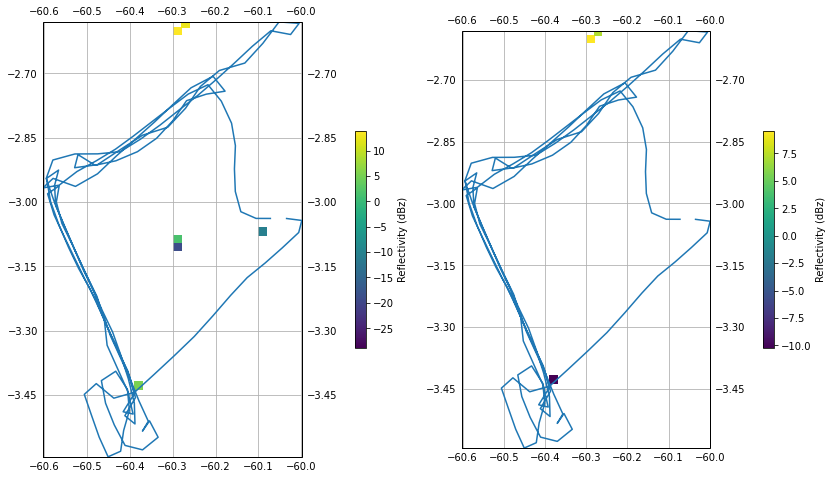

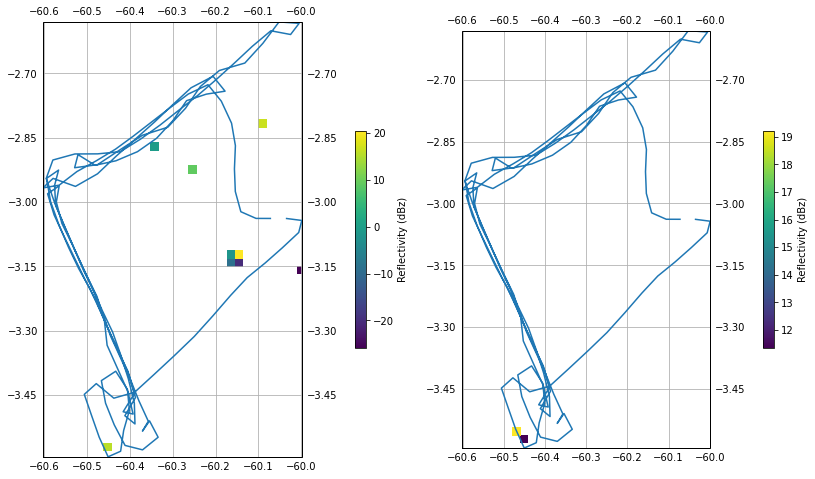

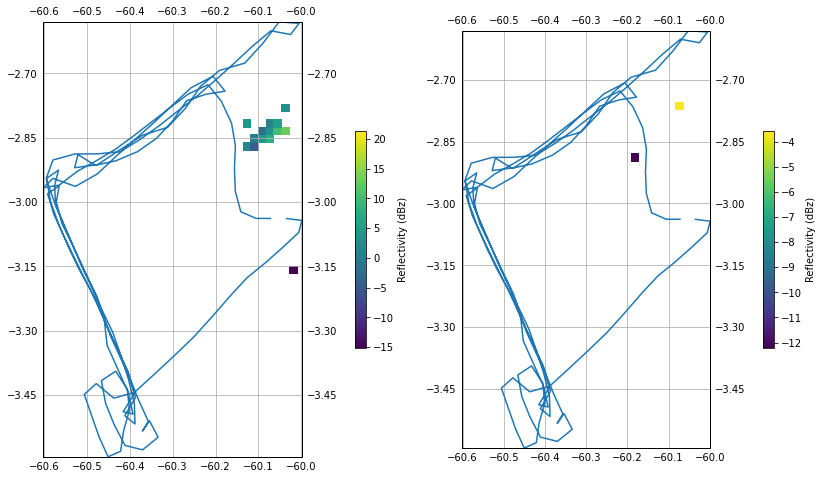

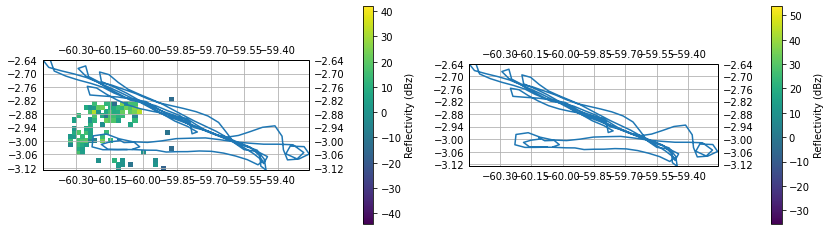

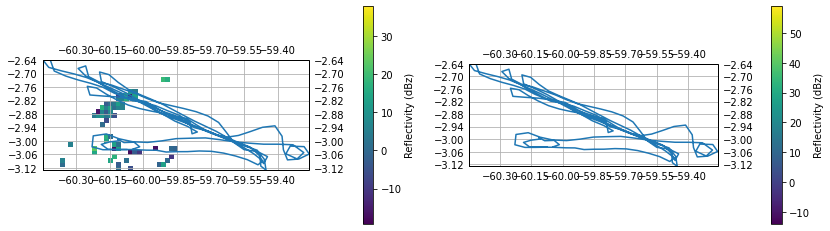

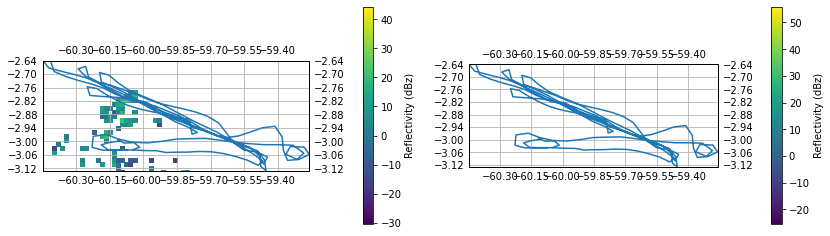

In [43]:
for ct in range(51):

    left_alt = left_alt_arr[ct]
    right_alt = right_alt_arr[ct]

    d = Dataset(files6[ct])
    i = files1[ct_arr[ct]]
    j = files4[ct_arr[ct]]

    dateiso = dateiso_arr_1[ct]

    # i = files1[0]
    # j = files4[0]
    # dateiso = '2014-03-01'


    lat_timeseries = np.array(params_lat(i,j)['Lat'])
    lon_timeseries = np.array(params_lat(i,j)['Lon'])

    fig = plt.figure(figsize = (14, 8))

    ax = fig.add_subplot(121, projection=ccrs.PlateCarree())
    cm = ax.pcolormesh((d.variables['lon0']),d.variables['lat0'],((d.variables['DBZc'])[0,left_alt,:,:]).T)
    # divider = make_axes_locatable(ax)
    # cax = divider.append_axes("right", size="5%", pad=0.15)
    # axcb = fig.colorbar(cm, cax = cax)
    axcb = fig.colorbar(cm, fraction = 0.1, shrink = 0.50, pad = 0.15)
    axcb.set_label('Reflectivity (dBz)')

    ax.plot(lon_timeseries, lat_timeseries)
    ax.set_xlim(min(lon_timeseries), max(lon_timeseries))
    ax.set_ylim(min(lat_timeseries), max(lat_timeseries))
    # ax.set_aspect('auto')
    ax.gridlines(draw_labels = True)

    ax1 = fig.add_subplot(122, projection=ccrs.PlateCarree())
    cm1 = ax1.pcolormesh((d.variables['lon0']),d.variables['lat0'],((d.variables['DBZc'])[0,right_alt,:,:]).T)
    axcb1 = fig.colorbar(cm1, shrink = 0.50, pad = 0.15)
    axcb1.set_label('Reflectivity (dBz)')

    ax1.plot(lon_timeseries, lat_timeseries)
    ax1.set_xlim(min(lon_timeseries), max(lon_timeseries))
    ax1.set_ylim(min(lat_timeseries), max(lat_timeseries))
    ax1.gridlines(draw_labels = True)

    # plt.subplots_adjust(wspace = 0.3)
    # plt.suptitle(f'Left plot altitude = {left_alt} km,                     Date: {dateiso}                    Right plot altitude = {right_alt}km', y = 0.8)
    plt.show()
    # plt.tight_layout(rect=[0, 0.03, 1, 0.2])